In [5]:
import matplotlib.pyplot as plt

In [21]:
class BayesianInference:
    #Konstruktor klasy
    def __init__(self):
        """Zbiór wszystkich prawdopodobieństw"""
        self.probabilities = {}

    #Metoda ustawiania prawdopodobieństwa
    def set_probability(self, event, given, value):
        """Przykład: p(b|I) = value -> set_probability('b', 'I', value)"""

        self.probabilities[(event, given)] = value

    #Metoda dostępu do wartości prawdopodobieństw
    def get_probability(self, event, given=None):
        """Przykład: get_probability('b', 'I') -> p(b|I)    JEŻELI 'given' is None -> p(b)."""

        if given is not None:
            # Jeśli nie ma p(event|given), próbujemy obliczyć z reguły Bayesa
            if self.probabilities.get((event, given), None) is None:
                # Próbujemy obliczyć z reguły Bayesa: p(event|given) = p(given|event) * p(event) / p(given)
                reverse_prob = self.probabilities.get((given, event), None)
                marginal_event = self.probabilities.get((event, None), None)
                marginal_given = self.probabilities.get((given, None), None)

                if reverse_prob is not None and marginal_event is not None and marginal_given is not None:
                    prob = (reverse_prob * marginal_event) / marginal_given
                    self.set_probability(event, given, prob)  # Zapisujemy policzoną wartość
                    return prob
                else:
                    return None  # Nie możemy policzyć brakujących prawdopodobieństw
            return self.probabilities.get((event, given), None)
        else:
            # Marginalne prawdopodobieństwo p(event)
            return self.probabilities.get((event, None), None)

    #Metoda obliczania prawdopodobieństw z wielu dowodów
    def calculate_posterior(self, target, evidence):
        """Przykład: p(I|a,b) = (p(b|I)/p(b)) * p(I|a)"""
        posterior = 1  # Zaczynamy od neutralnego iloczynu
        for i, ev in enumerate(evidence):
            if i == 0:
                # Dla pierwszego dowodu: p(target | evidence)
                p_target_given_ev = self.get_probability(target, ev)
                if p_target_given_ev is None:
                    raise ValueError(f"Brak możliwości obliczenia p({target}|{ev})")
                posterior *= p_target_given_ev
            else:
                # Dla kolejnych dowodów: p(ev | target) / p(ev)
                p_ev_given_target = self.get_probability(ev, target)
                p_ev = self.get_probability(ev)
                
                if p_ev_given_target is None or p_ev is None:
                    raise ValueError(f"Brak możliwości obliczenia p({ev}|{target}) lub p({ev})")

                # Obliczamy iloraz
                posterior *= p_ev_given_target / p_ev
        
        return posterior
        

In [22]:
bayes = BayesianInference()

#Przekazanie prawdopodobieństw
bayes.set_probability('b', 'I', 0.98)       # p(b|I)
bayes.set_probability('a', 'I', 0.8)        # p(a|I)
bayes.set_probability('a', None, 0.01)      # p(a)
bayes.set_probability('b', None, 0.5)       # p(b)
bayes.set_probability('I', None, 0.002)     # p(I)
#bayes.set_probability('I', 'a', 0.16)      # p(I|a)

posterior = bayes.calculate_posterior('I', ['a', 'b'])

print(f"Prawdopodobieństwo włamania wynosi: {posterior:.4f}")

Prawdopodobieństwo włamania wynosi: 0.3136


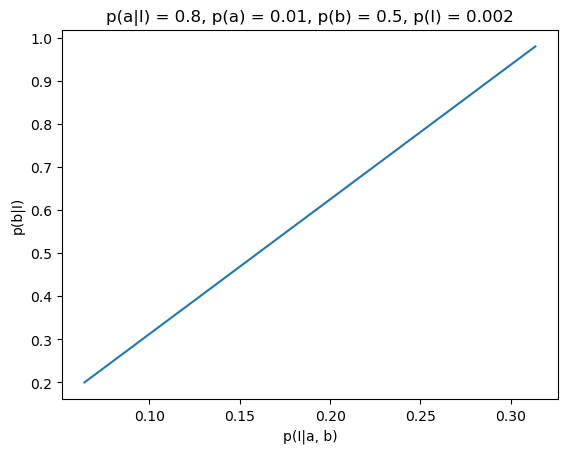

In [20]:
pBI = [0.2, 0.4, 0.6, 0.8, 0.98]
posteriors = []

for i, pBI_value in enumerate(pBI):
    bayes = BayesianInference()
    bayes.set_probability('b', 'I', pBI_value)  # p(b|I)
    bayes.set_probability('a', 'I', 0.8)        # p(a|I)
    bayes.set_probability('a', None, 0.01)      # p(a)
    bayes.set_probability('b', None, 0.5)       # p(b)
    bayes.set_probability('I', None, 0.002)     # p(I)

    posteriors.append(bayes.calculate_posterior('I', ['a', 'b']))

plt.title('p(a|I) = 0.8, p(a) = 0.01, p(b) = 0.5, p(I) = 0.002')
plt.plot(posteriors, pBI)
plt.xlabel('p(I|a, b)')
plt.ylabel('p(b|I)')
plt.show()

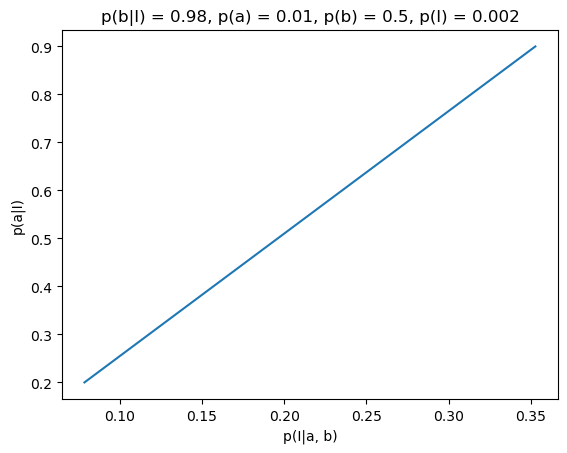

In [19]:
pAI = [0.2, 0.4, 0.6, 0.8, 0.9]
posteriors = []

for i, pAI_value in enumerate(pAI):
    bayes = BayesianInference()
    bayes.set_probability('b', 'I', 0.98)       # p(b|I)
    bayes.set_probability('a', 'I', pAI_value)  # p(a|I)
    bayes.set_probability('a', None, 0.01)      # p(a)
    bayes.set_probability('b', None, 0.5)       # p(b)
    bayes.set_probability('I', None, 0.002)     # p(I)

    posteriors.append(bayes.calculate_posterior('I', ['a', 'b']))

plt.title('p(b|I) = 0.98, p(a) = 0.01, p(b) = 0.5, p(I) = 0.002')
plt.plot(posteriors, pAI)
plt.xlabel('p(I|a, b)')
plt.ylabel('p(a|I)')
plt.show()